# Using PyTorch to create a self driving TORCS model

## Hyper parameters

In [38]:
import math
EPOCHS = 100
INITIAL_BATCH_SIZE = 1024
BATCH_SIZE = 2048
LEARNING_RATE = 0.001 * math.sqrt(BATCH_SIZE / INITIAL_BATCH_SIZE)

0.001

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
from tqdm.auto import tqdm
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import pickle
import os
from datetime import datetime
from torch.cuda.amp import GradScaler, autocast



## Load the data

In [19]:
# Get list of files in new_data folder
files = os.listdir('new_data')
files

['aalborg_15_1_1.csv',
 'aalborg_20_1_0.csv',
 'alpine1_10_10_0.csv',
 'alpine1_17_10_1.csv',
 'alpine1_20_7_2.csv',
 'alpine2_20_5_1.csv',
 'alpine2_28_10_0.csv',
 'cgspeedwaynumber1_30_10_0.csv',
 'cgtrack2_25_10_0.csv',
 'cgtrack3_25_10_0.csv',
 'corkscrew_30_10_0.csv',
 'corkscrew_30_10_1.csv',
 'eroad_30_10_0.csv',
 'etrack3_20_10_0.csv',
 'etrack4_20_10_0.csv',
 'etrack6_30_10_0.csv',
 'forza_25_10_0.csv',
 'olethrosroad1_25_10_0.csv',
 'ruudskogen_25_10_0.csv',
 'spring_7_10_0.csv',
 'street1_10_7_1.csv',
 'street1_20_7_0.csv',
 'wheel1_10_10_1.csv',
 'wheel1_20_10_0.csv',
 'wheel2_10_8_1.csv',
 'wheel2_20_8_0.csv']

In [20]:
# Merge all csv files from new_data folder
df = pd.read_csv(f"new_data/{files[0]}")
df.head()

,Angle,CurrentLapTime,Damage,DistanceFromStart,DistanceCovered,FuelLevel,Gear,LastLapTime,Opponent_1,Opponent_2,...,WheelSpinVelocity_1,WheelSpinVelocity_2,WheelSpinVelocity_3,WheelSpinVelocity_4,Z,Acceleration,Braking,Clutch,Gear,Steering
0,0.000705,-0.982,0.0,2562.53,0.0,94.0000,0,0.0,30.1991,10.5431,...,0.0,0.0,0.0,0.0,0.339875,1.0,0.0,0.64,1,0.025884
1,0.000705,-0.962,0.0,2562.53,0.0,94.0000,0,0.0,30.1991,10.5431,...,0.0,0.0,0.0,0.0,0.339875,1.0,0.0,0.64,1,0.025884
2,0.000705,-0.942,0.0,2562.53,0.0,93.9999,0,0.0,30.1991,10.5431,...,0.0,0.0,0.0,0.0,0.339875,1.0,0.0,0.64,1,0.025884
3,0.000705,-0.922,0.0,2562.53,0.0,93.9998,0,0.0,30.1991,10.5431,...,0.0,0.0,0.0,0.0,0.339875,1.0,0.0,0.64,1,0.025884
4,0.000705,-0.902,0.0,2562.53,0.0,93.9997,0,0.0,30.1991,10.5431,...,0.0,0.0,0.0,0.0,0.339875,1.0,0.0,0.64,1,0.025884


In [21]:
dfs = [pd.read_csv(f'new_data/{file}') for file in files[1:]]
df = pd.concat(dfs, ignore_index=True)
df

,Angle,CurrentLapTime,Damage,DistanceFromStart,DistanceCovered,FuelLevel,Gear,LastLapTime,Opponent_1,Opponent_2,...,WheelSpinVelocity_1,WheelSpinVelocity_2,WheelSpinVelocity_3,WheelSpinVelocity_4,Z,Acceleration,Braking,Clutch,Gear,Steering
0,0.000705,-0.982000,0.0,2562.5300,0.0,94.0000,0,0.000,30.5055,10.5417,...,0.000,0.000,0.000,0.000,0.339875,1.0,0.0,0.64,1,0.025884
1,0.000705,-0.962000,0.0,2562.5300,0.0,94.0000,0,0.000,30.5055,10.5417,...,0.000,0.000,0.000,0.000,0.339875,1.0,0.0,0.64,1,0.025884
2,0.000705,-0.942000,0.0,2562.5300,0.0,93.9999,0,0.000,30.5055,10.5417,...,0.000,0.000,0.000,0.000,0.339875,1.0,0.0,0.64,1,0.025884
3,0.000705,-0.922000,0.0,2562.5300,0.0,93.9998,0,0.000,30.5055,10.5417,...,0.000,0.000,0.000,0.000,0.339875,1.0,0.0,0.64,1,0.025884
4,0.000705,-0.902000,0.0,2562.5300,0.0,93.9997,0,0.000,30.5055,10.5417,...,0.000,0.000,0.000,0.000,0.339875,1.0,0.0,0.64,1,0.025884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2400236,0.001335,0.850033,1058.0,60.2765,124230.0,10.4430,5,118.704,200.0000,200.0000,...,205.979,205.962,208.417,208.393,0.312639,1.0,0.0,0.00,5,0.000436
2400237,0.001265,0.872033,1058.0,61.7790,124232.0,10.4430,5,118.704,200.0000,200.0000,...,205.663,205.645,208.096,208.072,0.312497,1.0,0.0,0.00,5,0.000445
2400238,0.001193,0.894033,1058.0,63.2791,124233.0,10.4430,5,118.704,200.0000,200.0000,...,205.345,205.328,207.775,207.752,0.312330,1.0,0.0,0.00,5,0.000452
2400239,0.001122,0.916033,1058.0,64.7769,124235.0,10.4430,5,118.704,200.0000,200.0000,...,205.027,205.009,207.455,207.432,0.312184,1.0,0.0,0.00,5,0.000448


In [22]:
df.columns

Index(['Angle', ' CurrentLapTime', ' Damage', ' DistanceFromStart',
       ' DistanceCovered', ' FuelLevel', ' Gear', ' LastLapTime',
       ' Opponent_1', 'Opponent_2', 'Opponent_3', 'Opponent_4', 'Opponent_5',
       'Opponent_6', 'Opponent_7', 'Opponent_8', 'Opponent_9', 'Opponent_10',
       'Opponent_11', 'Opponent_12', 'Opponent_13', 'Opponent_14',
       'Opponent_15', 'Opponent_16', 'Opponent_17', 'Opponent_18',
       'Opponent_19', 'Opponent_20', 'Opponent_21', 'Opponent_22',
       'Opponent_23', 'Opponent_24', 'Opponent_25', 'Opponent_26',
       'Opponent_27', 'Opponent_28', 'Opponent_29', 'Opponent_30',
       'Opponent_31', 'Opponent_32', 'Opponent_33', 'Opponent_34',
       'Opponent_35', 'Opponent_36', 'RacePosition', ' RPM', ' SpeedX',
       ' SpeedY', ' SpeedZ', ' Track_1', 'Track_2', 'Track_3', 'Track_4',
       'Track_5', 'Track_6', 'Track_7', 'Track_8', 'Track_9', 'Track_10',
       'Track_11', 'Track_12', 'Track_13', 'Track_14', 'Track_15', 'Track_16',
       'T

# Prepare PyTorch Data

In [23]:
# def convert_gear_value(x):
#     return (x + 1) / 7

In [24]:
# df["Gear"].value_counts()

In [25]:
# df["Gear"] = df["Gear"].apply(convert_gear_value)
# df["Gear"].value_counts()

In [26]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [27]:
# Filter out only the columns we need
x_columns = [
    "Angle",
    " DistanceCovered",  # Distance raced
    # " Gear",
    " Opponent_1", "Opponent_2", "Opponent_3", "Opponent_4", "Opponent_5", "Opponent_6", "Opponent_7", "Opponent_8", "Opponent_9", "Opponent_10", "Opponent_11", "Opponent_12", "Opponent_13", "Opponent_14", "Opponent_15", "Opponent_16", "Opponent_17", "Opponent_18", "Opponent_19", "Opponent_20", "Opponent_21", "Opponent_22", "Opponent_23", "Opponent_24", "Opponent_25", "Opponent_26", "Opponent_27", "Opponent_28", "Opponent_29", "Opponent_30", "Opponent_31", "Opponent_32", "Opponent_33", "Opponent_34", "Opponent_35", "Opponent_36",
    " RPM",
    " SpeedX",
    " SpeedY",
    " SpeedZ",
    " Track_1", "Track_2", "Track_3", "Track_4", "Track_5", "Track_6", "Track_7", "Track_8", "Track_9", "Track_10", "Track_11", "Track_12", "Track_13", "Track_14", "Track_15", "Track_16", "Track_17", "Track_18", "Track_19",
    "TrackPosition",
    " WheelSpinVelocity_1",
    "WheelSpinVelocity_2",
    "WheelSpinVelocity_3",
    "WheelSpinVelocity_4",
    "Z",
]
y_columns = [" Acceleration", "Braking", "Steering"]
# y_columns = [" Acceleration", "Braking", "Steering", "Gear"]

In [28]:
# Select relevant columns for features and target
features = df[x_columns]
targets = df[y_columns]

# Normalize features
scaler = StandardScaler()
features = scaler.fit_transform(features)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2,)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device)
y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device)


In [29]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [30]:
X_train.shape[1], y_train.shape[1]

(67, 3)

## Creating the model

In [31]:
class Model(nn.Module):
    def __init__(self, input_size, output_size):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 32)
        self.fc7 = nn.Linear(32, 16)
        self.fc8 = nn.Linear(16, 8)
        self.fc9 = nn.Linear(8, output_size)
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = torch.relu(self.fc6(x))
        x = torch.relu(self.fc7(x))
        x = torch.relu(self.fc8(x))
        x = self.fc9(x)
        return x
    
model = Model(X_train.shape[1], y_train.shape[1]).to(device)
print(X_train.shape[1], y_train.shape[1])
    

67 3


## Training the model

In [32]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_loss = []
test_losses = []
train_r2 = []
test_r2 = []

def evaluate_in_batches(model, data_loader, device):
    all_preds = []
    all_targets = []
    model.eval()
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            all_preds.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    return np.concatenate(all_preds), np.concatenate(all_targets)

for epoch in tqdm(range(EPOCHS)):
    model.train()
    running_loss = 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    train_loss.append(epoch_loss)
    torch.cuda.empty_cache()

    # Evaluation
    train_preds, train_targets = evaluate_in_batches(model, train_loader, device)
    test_preds, test_targets = evaluate_in_batches(model, test_loader, device)

    train_r2_score = r2_score(train_targets, train_preds)
    test_r2_score = r2_score(test_targets, test_preds)

    train_r2.append(train_r2_score)
    test_r2.append(test_r2_score)

    test_preds_tensor = torch.tensor(test_preds, device=device)
    test_targets_tensor = torch.tensor(test_targets, device=device)
    test_loss = criterion(test_preds_tensor, test_targets_tensor).item()
    test_losses.append(test_loss)

    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {epoch_loss}, Test Loss: {test_loss}, Test R2: {test_r2_score}, Train R2: {train_r2_score}')


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Train Loss: 0.033769774839961166, Test Loss: 0.012699704617261887, Test R2: 0.7570254179421964, Train R2: 0.7605479314480902
Epoch 2/100, Train Loss: 0.009992050054395742, Test Loss: 0.009063622914254665, Test R2: 0.82226511595547, Train R2: 0.8270707190788461
Epoch 3/100, Train Loss: 0.008241206653781537, Test Loss: 0.008533461019396782, Test R2: 0.8368708319419453, Train R2: 0.8440752763056655
Epoch 4/100, Train Loss: 0.007358954963969317, Test Loss: 0.007036639843136072, Test R2: 0.8658162309490846, Train R2: 0.8713625267116599
Epoch 5/100, Train Loss: 0.006769679871741246, Test Loss: 0.006970094051212072, Test R2: 0.8692193688684697, Train R2: 0.875926817460266
Epoch 6/100, Train Loss: 0.006210862401761671, Test Loss: 0.005929750390350819, Test R2: 0.8862526937852991, Train R2: 0.8938281089168338
Epoch 7/100, Train Loss: 0.00584510263891569, Test Loss: 0.006807736121118069, Test R2: 0.8783120802778908, Train R2: 0.8860244205108856
Epoch 8/100, Train Loss: 0.00551895498

## Results

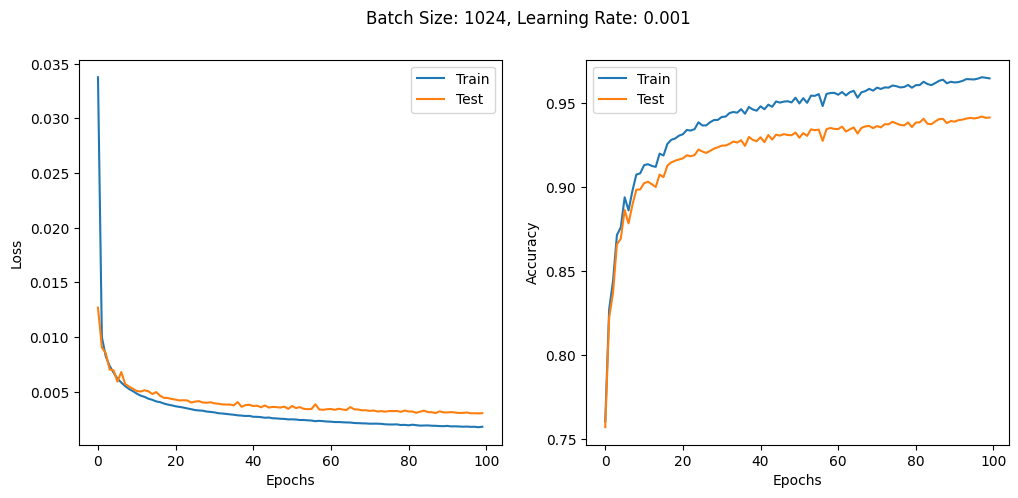

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))


ax1.plot(train_loss, label='Train')
ax1.plot(test_losses, label='Test')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(train_r2, label='Train')
ax2.plot(test_r2, label='Test')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

fig.suptitle(f'Batch Size: {BATCH_SIZE}, Learning Rate: {LEARNING_RATE}')
plt.show()

fig.savefig(f'graphs/lost_accuracy_{BATCH_SIZE}.png')


## Saving the model and scaler

In [34]:
# Generate timestamp
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# Save model with timestamp
model_path = f'models/model_{timestamp}.pth'
torch.save(model.state_dict(), model_path)

# Save scaler with timestamp
scaler_path = f'models/scaler_{timestamp}.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)